<a href="https://colab.research.google.com/github/nachiiiket/OptiexIOT_FinalScripts/blob/main/RandomForestRegressor_OPTIEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# -----------------
# Load dataset
# -----------------
df = pd.read_csv("/content/optiex_mongo_database_5575.csv")

# Ensure timestamp is datetime
df['device_timestamp'] = pd.to_datetime(df['device_timestamp'])
df = df.sort_values('device_timestamp')

# Target variable
df['y'] = df['value']



In [3]:
# -----------------
# Feature Engineering
# -----------------
df['lag1'] = df['y'].shift(1)
df['lag2'] = df['y'].shift(2)
df['lag3'] = df['y'].shift(3)
df['roll_mean3'] = df['y'].rolling(window=3).mean()
df['roll_mean7'] = df['y'].rolling(window=7).mean()
df['exp_std'] = df['y'].ewm(span=5).std()
df['month'] = df['device_timestamp'].dt.month
df['diff1'] = df['y'].diff()

# Drop NaN values from lag/rolling features
df = df.dropna()

In [4]:
# -----------------
# 80-20 Split
# -----------------
split_index = int(len(df) * 0.8)
train = df.iloc[:split_index]
test  = df.iloc[split_index:]

X_train = train[['lag1','lag2','lag3','roll_mean3','roll_mean7','exp_std','month','diff1']]
y_train = train['y']
X_test = test[['lag1','lag2','lag3','roll_mean3','roll_mean7','exp_std','month','diff1']]
y_test = test['y']



In [5]:
# -----------------
# Train model
# -----------------
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)



RandomForestRegressor(n_estimators=200, random_state=42)

In [6]:
# -----------------
# Predict & Evaluate
# -----------------
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
smape = 100 * np.mean(
    np.abs(y_test - y_pred) / ((np.abs(y_test) + np.abs(y_pred)) / 2 + 1e-8)
)

print("📊 Performance on 80-20 Split:")
print(f"MAE   = {mae:.6f}")
print(f"RMSE  = {rmse:.6f}")
print(f"SMAPE = {smape:.4f}%")

📊 Performance on 80-20 Split:
MAE   = 0.000980
RMSE  = 0.003192
SMAPE = 0.2558%


📊 Performance on Unseen Data:
MAE   = 0.000353
RMSE  = 0.001637
SMAPE = 0.0802%


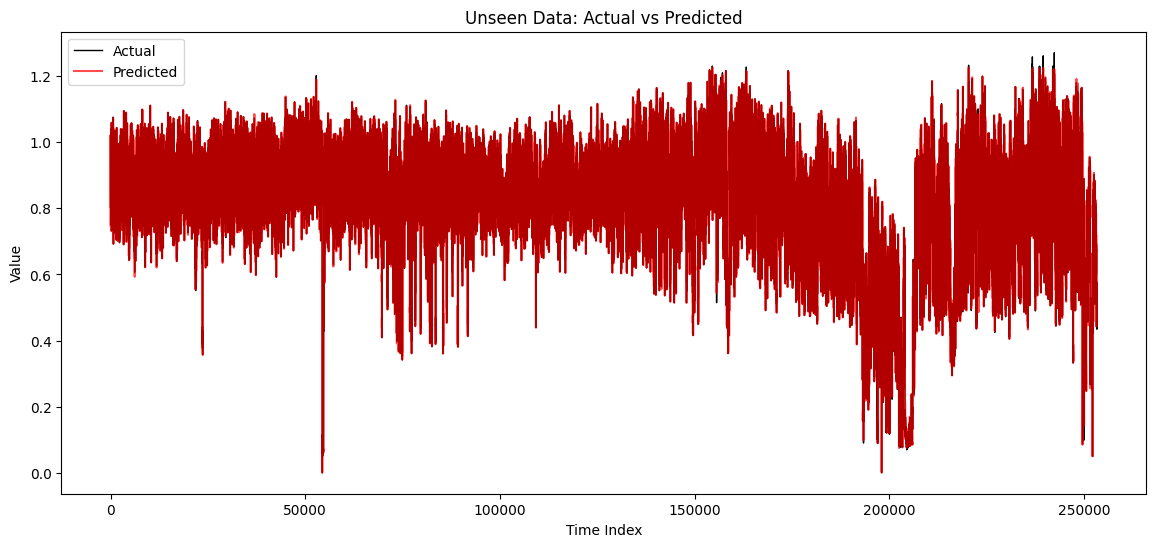

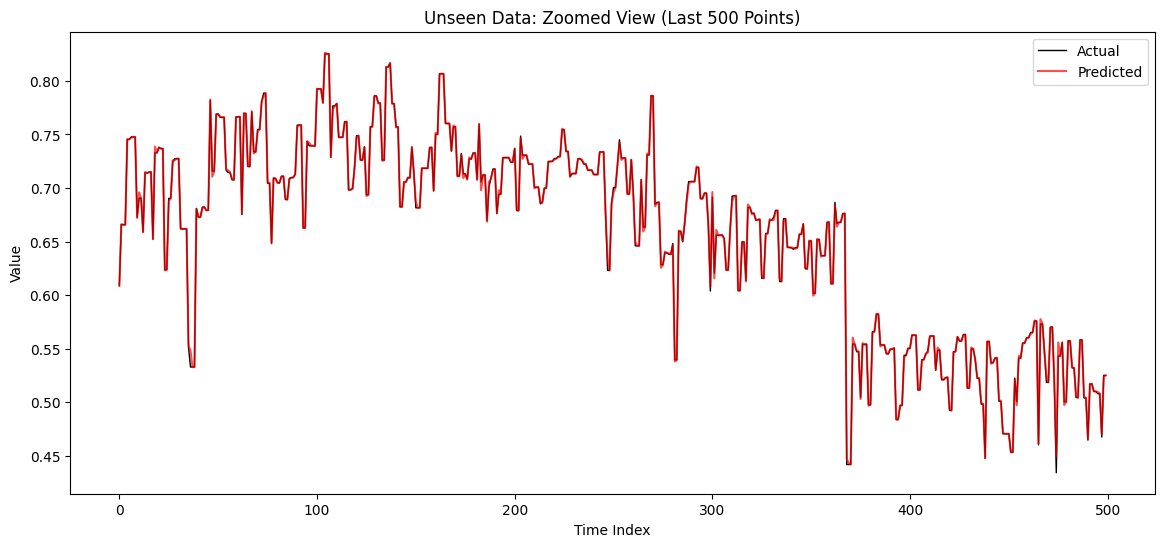

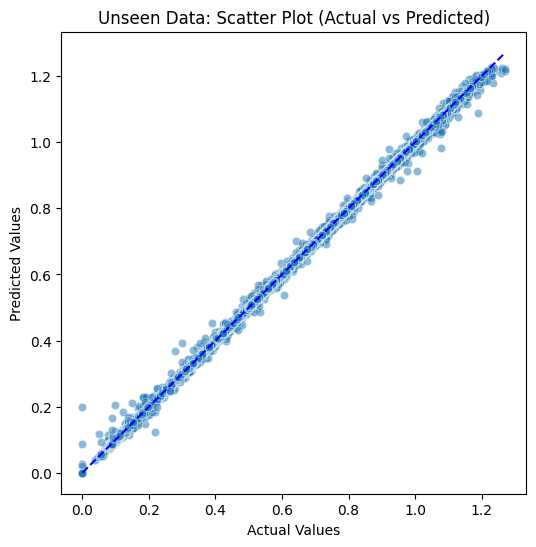

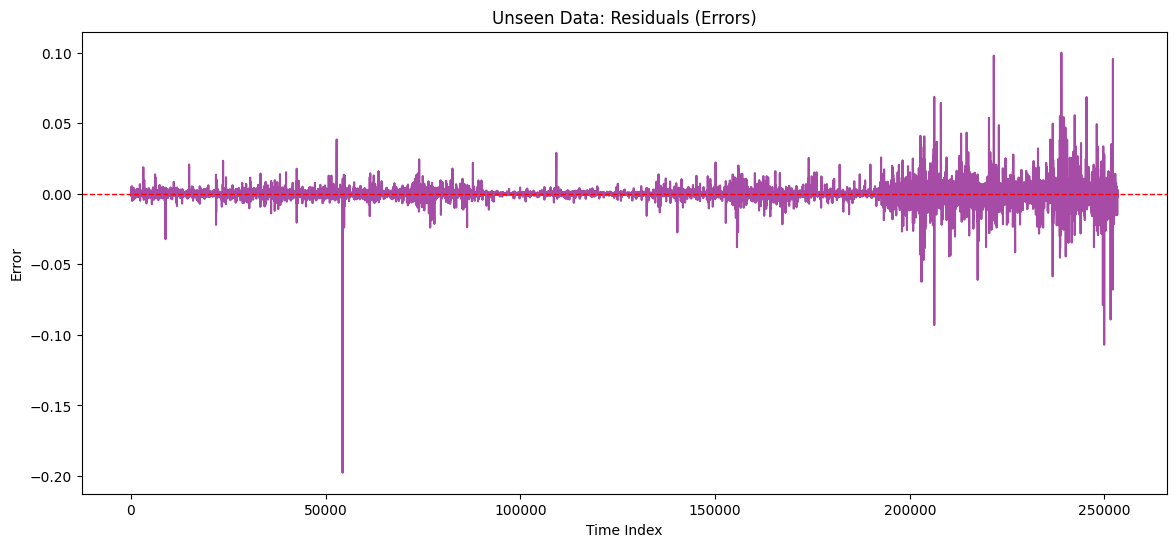

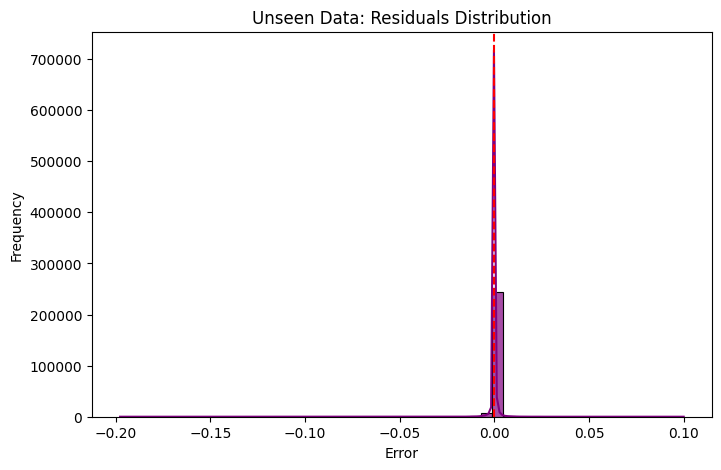

In [8]:
# -----------------
# Function to visualize results
# -----------------
def visualize_results(y_true, y_pred, title_prefix="Unseen Data"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 1. Line Plot (full series)
    plt.figure(figsize=(14,6))
    plt.plot(y_true, label="Actual", color="black", linewidth=1)
    plt.plot(y_pred, label="Predicted", color="red", alpha=0.7)
    plt.title(f"{title_prefix}: Actual vs Predicted")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # 2. Zoomed (last 500 points)
    plt.figure(figsize=(14,6))
    plt.plot(y_true[-500:], label="Actual", color="black", linewidth=1)
    plt.plot(y_pred[-500:], label="Predicted", color="red", alpha=0.7)
    plt.title(f"{title_prefix}: Zoomed View (Last 500 Points)")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # 3. Scatter Plot
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
             color="blue", linestyle="--", linewidth=1.5)
    plt.title(f"{title_prefix}: Scatter Plot (Actual vs Predicted)")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

    # 4. Residual Plot
    residuals = y_true - y_pred
    plt.figure(figsize=(14,6))
    plt.plot(residuals, color="purple", alpha=0.7)
    plt.axhline(0, color="red", linestyle="--", linewidth=1)
    plt.title(f"{title_prefix}: Residuals (Errors)")
    plt.xlabel("Time Index")
    plt.ylabel("Error")
    plt.show()

    # 5. Residual Distribution
    plt.figure(figsize=(8,5))
    sns.histplot(residuals, bins=50, kde=True, color="purple", alpha=0.7)
    plt.axvline(0, color="red", linestyle="--", linewidth=1.5)
    plt.title(f"{title_prefix}: Residuals Distribution")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.show()

# -----------------
# Load Unseen Data
# -----------------
df_unseen = pd.read_csv("/content/optiex_mongo_database_5575.csv")  # change path if needed

# Ensure timestamp is datetime
df_unseen['device_timestamp'] = pd.to_datetime(df_unseen['device_timestamp'])
df_unseen = df_unseen.sort_values('device_timestamp')

# Target variable
df_unseen['y'] = df_unseen['value']

# -----------------
# Feature Engineering (same as training)
# -----------------
df_unseen['lag1'] = df_unseen['y'].shift(1)
df_unseen['lag2'] = df_unseen['y'].shift(2)
df_unseen['lag3'] = df_unseen['y'].shift(3)
df_unseen['roll_mean3'] = df_unseen['y'].rolling(window=3).mean()
df_unseen['roll_mean7'] = df_unseen['y'].rolling(window=7).mean()
df_unseen['exp_std'] = df_unseen['y'].ewm(span=5).std()
df_unseen['month'] = df_unseen['device_timestamp'].dt.month
df_unseen['diff1'] = df_unseen['y'].diff()

# Drop NaN values
df_unseen = df_unseen.dropna()

# Features
X_unseen = df_unseen[['lag1','lag2','lag3','roll_mean3','roll_mean7','exp_std','month','diff1']]
y_unseen = df_unseen['y']

# -----------------
# Predict with pre-trained model
# -----------------
y_pred_unseen = model.predict(X_unseen)

# -----------------
# Evaluate Performance
# -----------------
mae_unseen = mean_absolute_error(y_unseen, y_pred_unseen)
rmse_unseen = np.sqrt(mean_squared_error(y_unseen, y_pred_unseen))
smape_unseen = 100 * np.mean(np.abs(y_unseen - y_pred_unseen) / ((np.abs(y_unseen) + np.abs(y_pred_unseen)) / 2 + 1e-8))

print("📊 Performance on Unseen Data:")
print(f"MAE   = {mae_unseen:.6f}")
print(f"RMSE  = {rmse_unseen:.6f}")
print(f"SMAPE = {smape_unseen:.4f}%")

# -----------------
# Visualize Results
# -----------------
visualize_results(y_unseen, y_pred_unseen, title_prefix="Unseen Data")
